In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import isoweek
import pathlib

Les données de l'incidence du syndrome grippal sont disponibles du site Web du [Réseau Sentinelles](http://www.sentiweb.fr/). Nous les récupérons sous forme d'un fichier en format CSV dont chaque ligne correspond à une semaine de la période demandée. Nous téléchargeons toujours le jeu de données complet, qui commence en 1984 et se termine avec une semaine récente.

In [2]:
data_url = "https://www.sentiweb.fr/datasets/incidence-PAY-7.csv"

Voici l'explication des colonnes données [sur le site d'origine](https://ns.sentiweb.fr/incidence/csv-schema-v1.json):

| Nom de colonne | Libellé de colonne                                                                                                                |
|----------------|-----------------------------------------------------------------------------------------------------------------------------------|
| week           | Semaine calendaire (ISO 8601)                                                                                                     |
| indicator      | Code de l'indicateur de surveillance                                                                                              |
| inc            | Estimation de l'incidence de consultations en nombre de cas                                                                       |
| inc_low        | Estimation de la borne inférieure de l'IC95% du nombre de cas de consultation                                                     |
| inc_up         | Estimation de la borne supérieure de l'IC95% du nombre de cas de consultation                                                     |
| inc100         | Estimation du taux d'incidence du nombre de cas de consultation (en cas pour 100,000 habitants)                                   |
| inc100_low     | Estimation de la borne inférieure de l'IC95% du taux d'incidence du nombre de cas de consultation (en cas pour 100,000 habitants) |
| inc100_up      | Estimation de la borne supérieure de l'IC95% du taux d'incidence du nombre de cas de consultation (en cas pour 100,000 habitants) |
| geo_insee      | Code de la zone géographique concernée (Code INSEE) http://www.insee.fr/fr/methodes/nomenclatures/cog/                            |
| geo_name       | Libellé de la zone géographique (ce libellé peut être modifié sans préavis)                                                       |

La première ligne du fichier CSV est un commentaire, que nous ignorons en précisant `skiprows=1`.

In [3]:
if pathlib.Path("incidence-PAY-7.csv").exists():
    raw_data = pd.read_csv("incidence-PAY-7.csv")
else:
    raw_data = pd.read_csv(data_url, skiprows=1)
    raw_data.to_csv("incidence-PAY-7.csv", index=False)
raw_data.head()

week  indicator   inc  inc_low  inc_up  inc100  inc100_low  inc100_up  \
0  202121          7  6232     3541    8923       9           5         13   
1  202120          7  7519     4624   10414      11           7         15   
2  202119          7  6654     4370    8938      10           7         13   
3  202118          7  3912     2110    5714       6           3          9   
4  202117          7  4686     2878    6494       7           4         10   

  geo_insee geo_name  
0        FR   France  
1        FR   France  
2        FR   France  
3        FR   France  
4        FR   France

Y a-t-il des points manquants dans ce jeux de données ? Oui, la semaine 19 de l'année 1989 n'a pas de valeurs associées.

In [4]:
raw_data[raw_data.isnull().any(axis=1)]

Empty DataFrame
Columns: [week, indicator, inc, inc_low, inc_up, inc100, inc100_low, inc100_up, geo_insee, geo_name]
Index: []

Nous éliminons ce point, ce qui n'a pas d'impact fort sur notre analyse qui est assez simple.

In [5]:
data = raw_data.dropna().copy()
data.head()

week  indicator   inc  inc_low  inc_up  inc100  inc100_low  inc100_up  \
0  202121          7  6232     3541    8923       9           5         13   
1  202120          7  7519     4624   10414      11           7         15   
2  202119          7  6654     4370    8938      10           7         13   
3  202118          7  3912     2110    5714       6           3          9   
4  202117          7  4686     2878    6494       7           4         10   

  geo_insee geo_name  
0        FR   France  
1        FR   France  
2        FR   France  
3        FR   France  
4        FR   France

Nos données utilisent une convention inhabituelle: le numéro de
semaine est collé à l'année, donnant l'impression qu'il s'agit
de nombre entier. C'est comme ça que Pandas les interprète.
  
Un deuxième problème est que Pandas ne comprend pas les numéros de
semaine.  Il faut lui fournir les dates de début et de fin de
semaine. Nous utilisons pour cela la bibliothèque `isoweek`.

Comme la conversion des semaines est devenu assez complexe, nous
écrivons une petite fonction Python pour cela. Ensuite, nous
l'appliquons à tous les points de nos donnés. Les résultats vont
dans une nouvelle colonne 'period'.

In [6]:
def convert_week(year_and_week_int):
    year_and_week_str = str(year_and_week_int)
    year = int(year_and_week_str[:4])
    week = int(year_and_week_str[4:])
    w = isoweek.Week(year, week)
    return pd.Period(w.day(0), 'W')

data['period'] = [convert_week(yw) for yw in data['week']]

Il restent deux petites modifications à faire.

Premièrement, nous définissons les périodes d'observation
comme nouvel index de notre jeux de données. Ceci en fait
une suite chronologique, ce qui sera pratique par la suite.

Deuxièmement, nous trions les points par période, dans
le sens chronologique.

In [7]:
sorted_data = data.set_index('period').sort_index()

Nous vérifions la cohérence des données. Entre la fin d'une période et
le début de la période qui suit, la différence temporelle doit être
zéro, ou au moins très faible. Nous laissons une "marge d'erreur"
d'une seconde.

Ceci s'avère tout à fait juste sauf pour deux périodes consécutives
entre lesquelles il manque une semaine.

Nous reconnaissons ces dates: c'est la semaine sans observations
que nous avions supprimées !

In [8]:
periods = sorted_data.index
for p1, p2 in zip(periods[:-1], periods[1:]):
    delta = p2.to_timestamp() - p1.end_time
    if delta > pd.Timedelta('1s'):
        print(p1, p2)

Un premier regard sur les données !

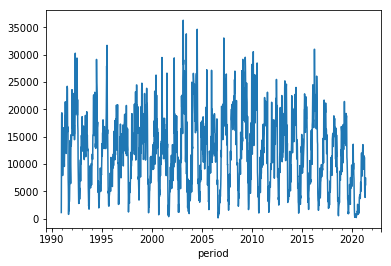

In [9]:
sorted_data['inc'].plot()

Un zoom sur les dernières années montre mieux la situation des pics en hiver. Le creux des incidences se trouve en été.

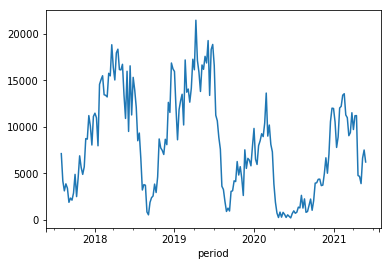

In [10]:
sorted_data['inc'][-200:].plot()

## Etude de l'incidence annuelle

Etant donné que le pic de l'épidémie se situe en hiver, à cheval
entre deux années civiles, nous définissons la période de référence
entre deux minima de l'incidence, du 1er août de l'année $N$ au
1er août de l'année $N+1$.

Notre tâche est un peu compliquée par le fait que l'année ne comporte
pas un nombre entier de semaines. Nous modifions donc un peu nos périodes
de référence: à la place du 1er août de chaque année, nous utilisons le
premier jour de la semaine qui contient le 1er septembre.

Comme l'incidence de syndrome grippal est très faible en été, cette
modification ne risque pas de fausser nos conclusions.

Encore un petit détail: les données commencent an octobre 1984, ce qui
rend la première année incomplète. Nous commençons donc l'analyse en 1985.

In [11]:
first_september_week = [pd.Period(pd.Timestamp(y, 9, 1), 'W')
                     for y in range(1991,
                                    sorted_data.index[-1].year)]

En partant de cette liste des semaines qui contiennent un 1er septembre, nous obtenons nos intervalles d'environ un an comme les périodes entre deux semaines adjacentes dans cette liste. Nous calculons les sommes des incidences hebdomadaires pour toutes ces périodes.

Nous vérifions également que ces périodes contiennent entre 51 et 52 semaines, pour nous protéger contre des éventuelles erreurs dans notre code.

In [12]:
year = []
yearly_incidence = []
for week1, week2 in zip(first_september_week[:-1],
                        first_september_week[1:]):
    one_year = sorted_data['inc'][week1:week2-1]
    print(week1, week2, one_year)
    assert abs(len(one_year)-52) < 2
    yearly_incidence.append(one_year.sum())
    year.append(week2.year)
yearly_incidence = pd.Series(data=yearly_incidence, index=year)

1991-08-26/1991-09-01 1992-08-31/1992-09-06 period
1991-08-26/1991-09-01      805
1991-09-02/1991-09-08     3053
1991-09-09/1991-09-15     1457
1991-09-16/1991-09-22     4446
1991-09-23/1991-09-29     3105
1991-09-30/1991-10-06     3615
1991-10-07/1991-10-13     6168
1991-10-14/1991-10-20     6419
1991-10-21/1991-10-27    14307
1991-10-28/1991-11-03     9882
1991-11-04/1991-11-10     8048
1991-11-11/1991-11-17     6453
1991-11-18/1991-11-24    12813
1991-11-25/1991-12-01    15370
1991-12-02/1991-12-08    13304
1991-12-09/1991-12-15    14115
1991-12-16/1991-12-22    15043
1991-12-23/1991-12-29    15184
1991-12-30/1992-01-05    23607
1992-01-06/1992-01-12    16588
1992-01-13/1992-01-19    18586
1992-01-20/1992-01-26    20690
1992-01-27/1992-02-02    15997
1992-02-03/1992-02-09    17009
1992-02-10/1992-02-16    22633
1992-02-17/1992-02-23    15243
1992-02-24/1992-03-01    21824
1992-03-02/1992-03-08    22906
1992-03-09/1992-03-15    20003
1992-03-16/1992-03-22    15838
1992-03-23/1992-03-

Voici les incidences annuelles.

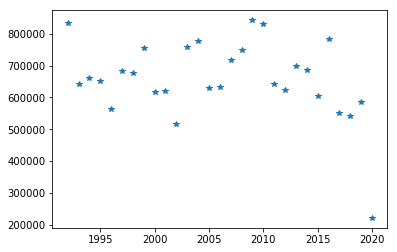

In [13]:
yearly_incidence.plot(style='*')

Une liste triée permet de plus facilement répérer les valeurs les plus élevées (à la fin).

In [14]:
yearly_incidence.sort_values()

2020    221186
2002    516689
2018    542312
2017    551041
1996    564901
2019    584066
2015    604382
2000    617597
2001    619041
2012    624573
2005    628464
2006    632833
2011    642368
1993    643387
1995    652478
1994    661409
1998    677775
1997    683434
2014    685769
2013    698332
2007    717352
2008    749478
1999    756456
2003    758363
2004    777388
2016    782114
2010    829911
1992    832939
2009    842373
dtype: int64

Enfin, un histogramme montre bien que les épidémies fortes, qui touchent environ 10% de la population
  française, sont assez rares: il y en eu trois au cours des 35 dernières années.

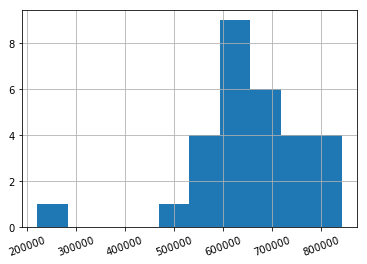

In [15]:
yearly_incidence.hist(xrot=20)